In [1]:
import json, torch, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive
# !unzip dataset.zip
# !unzip playlist_membership_data.zip
# !unzip fourier_data.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


# Load In The Data

In [3]:
if "dense_mtx.npy" in os.listdir():
    dense_mtx = np.load("dense_mtx.npy")
else:
    file_list = [x for x in os.listdir("./temp") if ".npy" in x]
    file_list.sort(key=lambda x : int(x.split("_")[2]))
    
    dense_mtx = np.zeros((22359, 10000))
    
    for idx, chunk in enumerate(file_list):
        chunk_offset = int(chunk.split("_")[2])
        mtx = np.load(f"./temp/{chunk}")
        if idx == len(file_list) - 1:
            num_elem = 59
        else:
            num_elem = 100
        dense_mtx[chunk_offset:chunk_offset+num_elem] = mtx
    
    np.save("dense_mtx.npy", dense_mtx)

In [4]:
labels = []
with open("./temp/npy_chunk_labels.txt", "r") as f:
    for line in f.readlines():
        line = line.strip().replace(".mp3", "")
        labels.append(line)
labels = np.array(labels)
assert(labels.size == dense_mtx.shape[0])

In [5]:
# Read in the JSON data
data_stream = ""
with open("challenge_set.json", "r") as f:
    data_stream = f.read()
data_set = json.loads(data_stream)


# Grab unique track/artist pairs
track_uris = set()
playlist_idcs = []

for i,j in enumerate(data_set["playlists"]):
    if len(j["tracks"]) == 100:
        playlist_idcs.append(i) 
        for track in j["tracks"]:
            track_uris.add((track["track_name"], track["artist_name"], track["track_uri"]))
unique_tracks = list(track_uris)

# Define mapping between URIs and trakcs
uri_to_title_artist_map = {x[2]: (x[0], x[1]) for x in unique_tracks}
# for i,(j,k) in enumerate(uri_to_title_artist_map.items()):
#     if i > 5: break
#     print(j,k)

# Rearranging data table
df = pd.read_csv("all_downloaded_data.csv")
df = df.drop("Unnamed: 0", axis=1)
df = df.set_index('uri')
df = df.drop_duplicates()

print(df.head())

                                      danceability  energy  key  loudness  \
uri                                                                         
spotify:track:38uqMByifM0mkjcTbejlyR         0.375   0.294    8    -8.751   
spotify:track:4kOTDj4SiZPkW1p96WMDNv         0.950   0.803    1    -4.195   
spotify:track:1c9LBfX0klXJscJAYDI0Ea         0.758   0.501    0    -7.051   
spotify:track:59iNA6gwthoTJ6IgpBGGHW         0.534   0.749    6    -5.562   
spotify:track:4QCng4MDyUhEZ730Ma2Rjp         0.674   0.744   11    -5.196   

                                      mode  speechiness  acousticness  \
uri                                                                     
spotify:track:38uqMByifM0mkjcTbejlyR     1       0.0329        0.9280   
spotify:track:4kOTDj4SiZPkW1p96WMDNv     1       0.1510        0.1450   
spotify:track:1c9LBfX0klXJscJAYDI0Ea     1       0.0589        0.2520   
spotify:track:59iNA6gwthoTJ6IgpBGGHW     0       0.0749        0.0776   
spotify:track:4QCng4MD

In [6]:
data_size = dense_mtx.shape[0]
test_dev_idcs = np.random.choice(data_size, replace=False, size=int(0.3*data_size))

dev_idcs = np.random.choice(test_dev_idcs.shape[0], replace=False, size=int((2/3) * test_dev_idcs.shape[0]))
selected_dev_uris = labels[test_dev_idcs[dev_idcs]]
dev_data = dense_mtx[test_dev_idcs[dev_idcs]]
dev_labels = df.loc[selected_dev_uris].iloc[:, 0:11].to_numpy()

print("dev")
print(dev_data.shape)
print(dev_labels.shape)

test_idcs = np.delete(test_dev_idcs, dev_idcs, axis=0)
selected_test_uris = labels[test_idcs]
test_data = dense_mtx[test_idcs]
test_labels = df.loc[selected_test_uris].iloc[:, 0:11].to_numpy()

print("test")
print(test_data.shape)
print(test_labels.shape)

train_idcs = np.delete(np.arange(data_size), test_dev_idcs, axis=0)
selected_train_uris = labels[train_idcs]
train_data = dense_mtx[train_idcs]
train_labels = df.loc[selected_train_uris].iloc[:, 0:11].to_numpy()

print("train")
print(train_data.shape)
print(train_labels.shape)

dev
(4471, 10000)
(4471, 11)
test
(2236, 10000)
(2236, 11)
train
(15652, 10000)
(15652, 11)


In [7]:
def normalize(data, mean, std):
    return (data - mean) / std 

train_data_means = train_data.mean(axis=0)
train_data_std = train_data.std(axis=0)
train_data = normalize(train_data, train_data_means, train_data_std)

train_label_means = train_labels.mean(axis=0)
train_label_std = train_labels.std(axis=0)
train_labels = normalize(train_labels, train_label_means, train_label_std) 

dev_data = normalize(dev_data, train_data_means, train_data_std)
dev_labels = normalize(dev_labels, train_label_means, train_label_std) 

test_data = normalize(test_data, train_data_means, train_data_std)
test_labels = normalize(test_labels, train_label_means, train_label_std) 

# Train A New Model 

In [8]:
#Don't run training on the CPU, wait until GPU is available or copy to another drive account and uncomment lines with .cuda or .cpu
#Remove this when training on GPU
raise ValueError() 

ValueError: ignored

In [ ]:
lr = 0.001
batch_size = 10000
epochs = 1000
dr = 0.5

In [ ]:
class RecommenderNet(torch.nn.Module):
    ### Implement your model's structure and input/filter/output dimensions
    def __init__(self, dr):
        super().__init__()
        
        self.lin1 = torch.nn.Linear(10_000, 5000)
        self.lin2 = torch.nn.Linear(5000, 1000)
        self.lin3 = torch.nn.Linear(1000, 100)
        self.lin4 = torch.nn.Linear(100, 11)

        self.dropout = torch.nn.Dropout(dr)

    def forward(self, x):
        x = torch.tanh(self.dropout(self.lin1(x)))
        x = torch.tanh(self.dropout(self.lin2(x)))
        x = torch.tanh(self.dropout(self.lin3(x)))
        x = self.lin4(x)
        return x


In [ ]:
# model = RecommenderNet(dr).cuda()
model = RecommenderNet(dr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_steps = []
train_losses = []
dev_steps = []
dev_losses = []

print(f"pct_complete, train_loss, dev_loss")
for step in range(epochs):
    model.train()
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    x = torch.from_numpy(train_data[i].astype(np.float32))
    y = torch.from_numpy(train_labels[i].astype(np.float32))

    # x, y = x.cuda(), y.cuda()
    
    prediction_idcs = model(x)
    loss = F.mse_loss(prediction_idcs, y) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_steps.append(step)
    train_losses.append(loss.item())
    
    if step % 10 == 0 or step == epochs-1:
        model.eval()
        dev_i = np.random.choice(dev_data.shape[0], size=1000, replace=False)
        dev_d = torch.from_numpy(dev_data[dev_i].astype(np.float32))
        dev_l = torch.from_numpy(dev_labels[dev_i].astype(np.float32))

        # dev_d, dev_l = dev_d.cuda(), dev_l.cuda()
        
        dev_pred = model(dev_d)
        dev_loss = F.mse_loss(dev_pred, dev_l)
        
        dev_steps.append(step)
        dev_losses.append(dev_loss.item())
        
        print(f"{(step/epochs) * 100:0.1f}% {loss.item():0.2f}, {dev_loss.item():0.2f}")
    

In [ ]:
plt.plot(train_steps, train_losses, 'b', label="train")
plt.plot(dev_steps, dev_losses, 'r', label='dev')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.gcf().set_size_inches(20,10)

file_name = "4_layer_linear_relu_relu_tanh"
torch.save(model, f"./models/{dev_losses[-1]:0.2f}_{file_name}.pth")
with open(f"./models/{dev_losses[-1]:0.2f}_{file_name}.pth.txt", "w") as f:
    f.write(f"dropout_rate, {dr}\n")
    f.write(f"learning_rate, {lr}\n")
    f.write(f"batch_size, {batch_size}\n")
    f.write(f"epochs, {epochs}\n")
    f.write(f"{str(model)}")

plt.title(f"Loss by Epoch: {dev_losses[-1]:0.2f}_{file_name}.pth")
plt.savefig(f"./models/{dev_losses[-1]:0.2f}_{file_name}.pth.png")

# Load Best Model

In [9]:
class RecommenderNet(torch.nn.Module):
    ### Implement your model's structure and input/filter/output dimensions
    def __init__(self, dr):
        super().__init__()
        
        self.lin1 = torch.nn.Linear(10_000, 1000)
        self.lin2 = torch.nn.Linear(1000, 100)
        self.lin3 = torch.nn.Linear(100, 11)

        self.dropout = torch.nn.Dropout(dr)

    def forward(self, x):
        x = torch.tanh(self.dropout(self.lin1(x)))
        x = torch.tanh(self.dropout(self.lin2(x)))
        x = self.lin3(x)
        return x

In [10]:
def un_normalize_model_output(output, t_mean, t_std):
    return  (output * t_std) + t_mean

In [11]:
best_model = torch.load("./models/0.74_3_layer_linear_relu_tanh.pth", map_location=torch.device("cpu"))
best_model.eval()
x = torch.from_numpy(test_data.astype(np.float32))
y = torch.from_numpy(test_labels.astype(np.float32))
# x, y = x.cuda(), y.cuda()

prediction_idcs = best_model(x)
loss = F.mse_loss(prediction_idcs, y) 

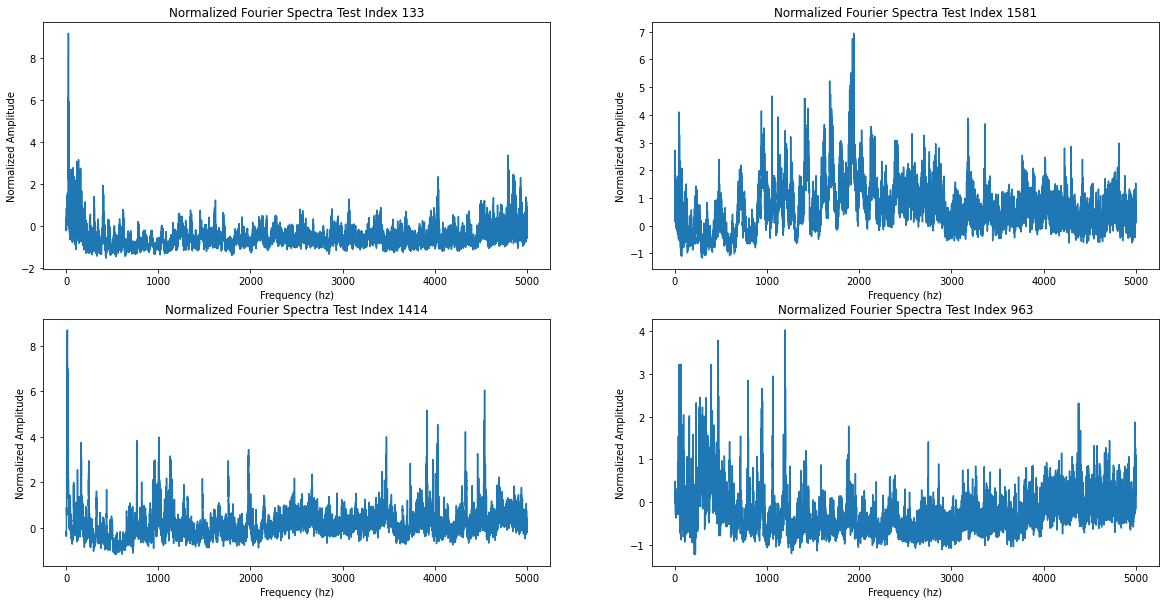

In [12]:
# pred = np.array(prediction_idcs.cpu().data)
# true = np.array(y.cpu().data)
pred = np.array(prediction_idcs.data)
true = np.array(y.data)

idx = np.random.choice(np.array(x.data).shape[0], 4, False)

fig, ((a1, a2),(a3, a4)) = plt.subplots(2, 2)
axes = [a1, a2, a3, a4]

for j, i in enumerate(idx):
    axes[j].set_title(f"Normalized Fourier Spectra Test Index {i}")
    max_freq = 5000 #hz
    freq_steps = np.linspace(0, max_freq, 10_000)
    axes[j].plot(freq_steps, np.array(x[i].data))
    axes[j].set_xlabel("Frequency (hz)")
    axes[j].set_ylabel("Normalized Amplitude")

fig.set_size_inches(20, 10)

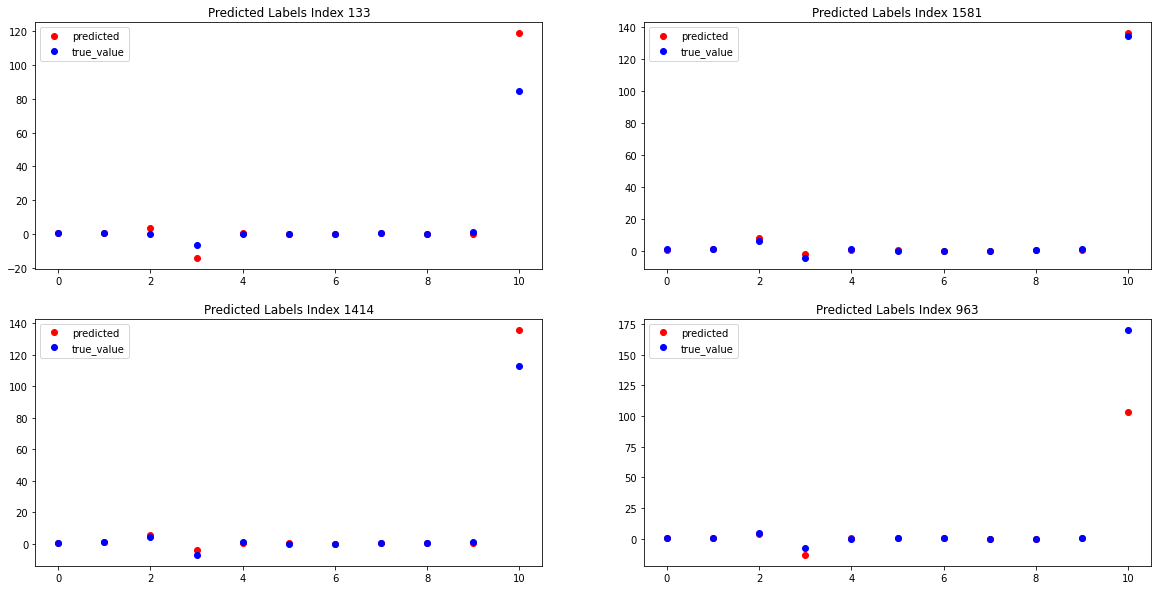

In [13]:
fig, ((a1, a2),(a3, a4)) = plt.subplots(2, 2)
axes = [a1, a2, a3, a4]

for j, i in enumerate(idx):
    predicted_unnormalized_data = un_normalize_model_output(pred[i], train_label_means, train_label_std)
    unnormalized_label = un_normalize_model_output(true[i], train_label_means, train_label_std)
    axes[j].plot(predicted_unnormalized_data, 'ro')
    axes[j].plot(unnormalized_label, 'bo')
    axes[j].legend(["predicted", "true_value"])
    # axes[j].axis([-0.5, 9.5, -10, 10]) # Un-comment this line to see classes 1-10 better, comment it to see class 11
    axes[j].set_title(f"Predicted Labels Index {i}")
fig.set_size_inches(20, 10)

# Run Model for Pre-Recorded Sound File Input

In [14]:
import scipy
from scipy.fftpack import fft
from scipy.io import wavfile

def visualize_waveform_and_fft(file_name, do_plot=False):
    fs_rate, signal = wavfile.read(file_name)
    l_audio = len(signal.shape)
    if l_audio == 2:
        signal = signal.sum(axis=1) / 2
    N = signal.shape[0]
    secs = N / float(fs_rate)
    Ts = 1.0/fs_rate # sampling interval in time
    t = np.arange(0, secs, Ts) # time vector as scipy arange field / numpy.ndarray
    FFT = abs(scipy.fft.fft(signal))
    FFT_side = FFT[range(N//2)] # one side FFT range
    freqs = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])
    fft_freqs = np.array(freqs)
    freqs_side = freqs[range(N//2)] # one side frequency range
    fft_freqs_side = np.array(freqs_side)
    if do_plot:
        plt.subplot(311)
        min_idx = min(len(t), len(signal))
        p1 = plt.plot(t[:min_idx], signal[:min_idx], "g") # plotting the signal
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.subplot(312)
        p2 = plt.plot(freqs, FFT, "r") # plotting the complete fft spectrum
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Count dbl-sided')
        plt.subplot(313)
        p3 = plt.plot(freqs_side, abs(FFT_side), "b") # plotting the positive fft spectrum
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Count single-sided')
        plt.gcf().set_size_inches(20,10)
    
    return freqs_side, abs(FFT_side)

In [15]:
def run_model_on_wav_file(file_name, do_plot=False):
    fft_freqs, fft_amp = visualize_waveform_and_fft(file_name, do_plot)
    if do_plot:
        plt.gcf().set_size_inches(10, 5)
        plt.show()
        plt.figure()
    
    largest_useful_frequency_idx =  sum([1 if x < 5000 else 0 for x in fft_freqs])
    number_of_samples = (largest_useful_frequency_idx // 10_000)
    
    trim_freqs = fft_freqs[:number_of_samples * 10_000]
    
    trim_amps = fft_amp[:number_of_samples * 10_000]
    trim_amps /= len(trim_amps)
    
    trans_freqs = trim_freqs.reshape(-1, number_of_samples).mean(axis=1)
    trans_amps = trim_amps.reshape(-1, number_of_samples).mean(axis=1)
    
    max_freq = 5000 #hz
    freq_steps = np.linspace(0, max_freq, 10_000)
    normalized_amps = torch.from_numpy(normalize(trans_amps, train_data_means, train_data_std).astype(np.float32))
    if do_plot:
        plt.plot(freq_steps, normalized_amps)
        plt.xlabel("Frequency (hz)")
        plt.ylabel("Normalized Amplitude")
        plt.title("Model Input: Normalized Fourier Frequencies")
        plt.gcf().set_size_inches(10, 5)
        plt.show()
    
    return un_normalize_model_output(np.array(best_model(normalized_amps).data), train_label_means, train_label_std)

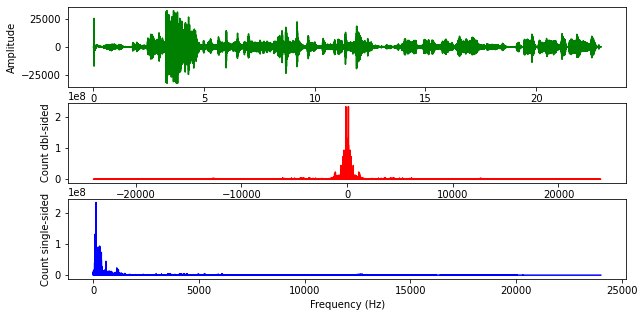

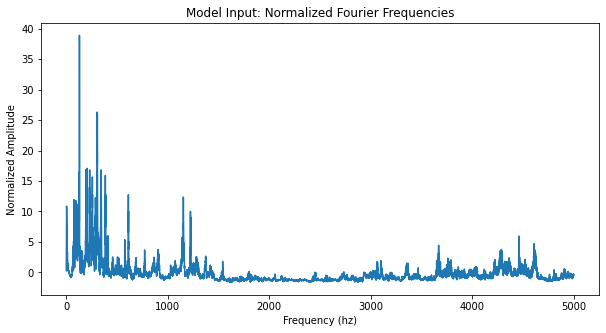

Predicts
[ 8.66219905e-01  9.70424022e-01  4.96494378e+00 -3.52241177e+00
  3.86700905e-01  2.18278046e-01 -2.34510021e-03  8.99330902e-02
  2.07424957e-01  9.06865061e-01  1.17127518e+02]


In [18]:
predictions = run_model_on_wav_file("despacito.wav", True) #Outputs the predicted spotify labels to input to clustering pathway.
print("Predicts")
print(predictions)

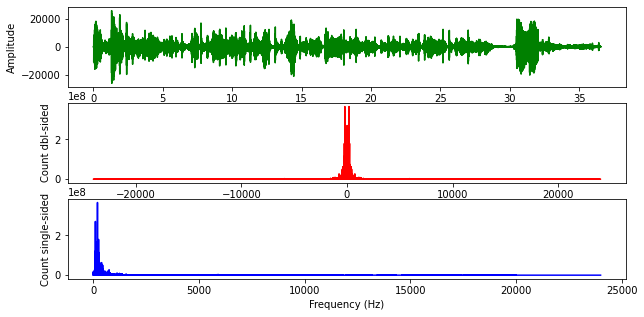

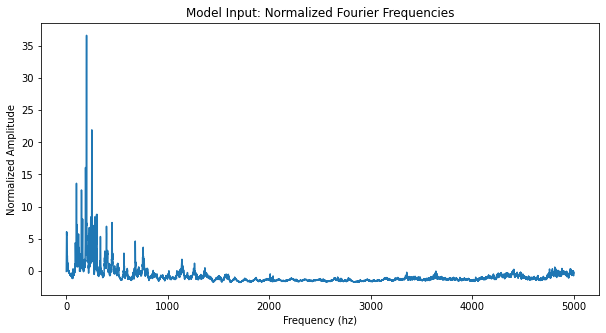

Predicts
[  0.74209352   0.62933829   4.63871189 -11.06962768   0.63935977
   0.12786552   0.41033174   0.25572808   0.18270345   0.9117149
 110.40103884]


In [17]:
predictions = run_model_on_wav_file("peach_pit.wav", True) #Outputs the predicted spotify labels to input to clustering pathway.
print("Predicts")
print(predictions)

# Record your own sound file to input to model

In [ ]:
%pip install ipywebrtc
%pip install ipywidgets

In [ ]:
!jupyter nbextension enable --py widgetsnbextension
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from ipywebrtc import AudioRecorder, CameraStream
from IPython.display import Audio

camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
# Hit the circle to record your own audio and input it to the neural network! Try to record for around 30 seconds.
recorder

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic
run_model_on_wav_file("file.wav")